# Trabajo Final

In [1]:
import warnings

import matplotlib.pyplot as plt
import medmnist
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from medmnist import INFO, Evaluator
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

torch.manual_seed(10)  # set seed for reproducibility
np.random.seed(10)

data_flag = "organsmnist"
download = True

info = INFO[data_flag]
task = info["task"]
n_channels = info["n_channels"]
n_classes = len(info["label"])

DataClass = getattr(medmnist, info["python_class"])

# Creando los datasets
Ahora procederemos a crear los datasets con las imágenes de training y de test. Aquí por simplicidad no utilizaremos la partición de validación, pero recordar que siempre se debe contar con una partición de validación para la selección de hiperparámetros y de modelo.

In [2]:
# Tamaño del batch de entrenamiento que será utilizado al generar los dataloaders
BATCH_SIZE = 128

# Transformaciones que serán utilizadas para normalizar las imagenes
data_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])]
)

# Creo los datasets
train_dataset = DataClass(split="train", transform=data_transform, download=download)
val_dataset = DataClass(split="val", transform=data_transform, download=download)
test_dataset = DataClass(split="test", transform=data_transform, download=download)

# Dataset que será utilizado solo para vbisualización (no incluye las transformaciones)
visual_dataset = DataClass(split="train", download=download)

# Encapsulo los datasets en un dataloader
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = data.DataLoader(
    dataset=val_dataset, batch_size=2 * BATCH_SIZE, shuffle=False
)
test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False
)

Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/organsmnist.npz
Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/organsmnist.npz
Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/organsmnist.npz
Using downloaded and verified file: /clusteruy/home/cmarino/.medmnist/organsmnist.npz


In [3]:
def get_counts_labels(loader):
    labels = []
    for _, label in loader:
        labels.extend(list(label[:, 0].numpy()))
    mapping = {int(k): v.capitalize() for (k, v) in info["label"].items()}
    mapping = np.vectorize(mapping.get)
    labels = mapping(labels)
    return pd.DataFrame(pd.Series(labels).value_counts())


counts_train = get_counts_labels(train_loader)
counts_val = get_counts_labels(val_loader)
counts_test = get_counts_labels(test_loader)

In [4]:
df = pd.concat([counts_train, counts_val, counts_test], axis=1)
df.columns = ["#Train", "#Val", "#Test"]
# df.index = df.index.rename("Organo")
df

,#Train,#Val,#Test
Liver,3464,491,2078
Pancreas,2004,280,1343
Spleen,1556,213,968
Bladder,1148,188,811
Kidney-left,1132,140,704
Kidney-right,1119,159,693
Lung-right,803,275,439
Lung-left,741,261,397
Heart,721,246,510
Femur-left,637,104,439


In [5]:
info["label"]

{'0': 'bladder',
 '1': 'femur-left',
 '2': 'femur-right',
 '3': 'heart',
 '4': 'kidney-left',
 '5': 'kidney-right',
 '6': 'liver',
 '7': 'lung-left',
 '8': 'lung-right',
 '9': 'pancreas',
 '10': 'spleen'}

# Visualizando las imágenes

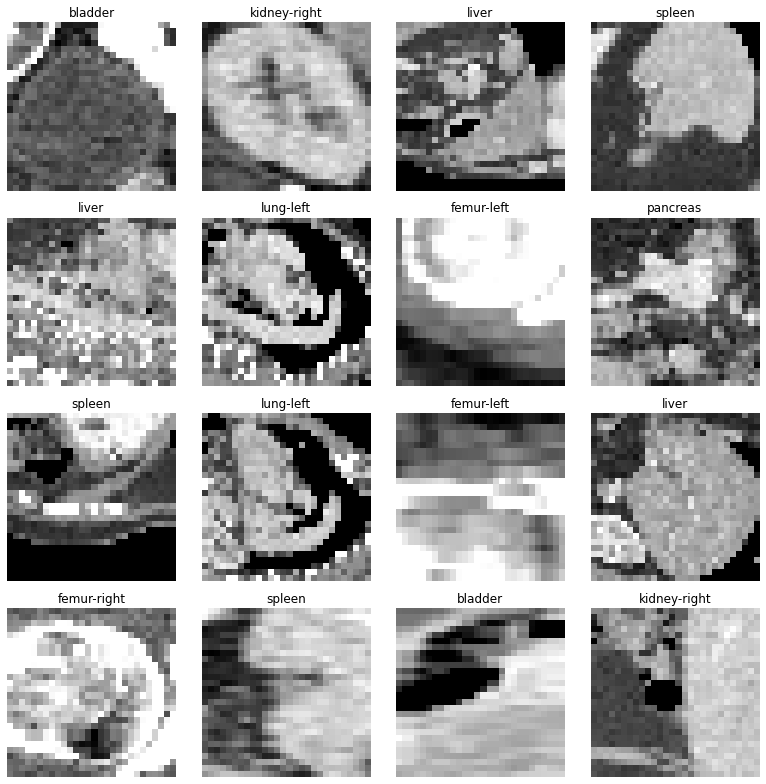

In [6]:
# Visualizamos algunas imágenes de ejemplo con sus etiquetas
offset = 0
plt.rcParams["figure.figsize"] = [11, 11]


fig = plt.figure()
for i in range(1 + offset, 17 + offset):
    ax = fig.add_subplot(4, 4, i - offset)
    img = visual_dataset[i][0]
    lbl = visual_dataset[i][1]
    ax.imshow(img, cmap="gray")
    ax.set_title(info["label"][str(lbl[0])])
    ax.axis(False)
fig.tight_layout()

In [7]:
fig.savefig("ejemplo_dataset.svg")

In [8]:
def trainer(
    net,
    train_loader,
    test_loader,
    *,
    num_epochs,
    input_features=28 * 28 * 3,
    learning_rate=0.001
):
    # Construimos el optimizador, y le indicamos que los parámetros a optimizar
    # son los del modelo definido: net.parameters()

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Definimos también la función de pérdida a utilizar
    criterion = nn.CrossEntropyLoss()

    # Creamos un loader iterable indicandole que debe leer los datos a partir de
    # del dataset creado en el paso anterior. Este objeto puede ser iterado
    # y nos devuelve de a un batch (x, y).

    # Lista en la que iremos guardando el valor de la función de pérdida en cada
    # etapa de entrenamiento
    loss_list = []

    acc_list = []
    acc_test_list = []
    iter_test_loader = iter(test_loader)

    # Bucle de entrenamiento
    for i in range(num_epochs):
        print("Epoch : " + str(i))
        loss_list_epoch = []
        # Itero sobre todos los batches del dataset
        for x, y in tqdm(train_loader):
            # Seteo en cero los gradientes de los parámetros a optimizar
            optimizer.zero_grad()

            # Movemos los tensores a memoria de GPU
            x = x.to(device)
            y = y.to(device)
            y = y.squeeze().long()
            pred = net(x)

            # Realizo la pasada forward por la red
            loss = criterion(pred, y)

            # Realizo la pasada backward por la red
            loss.backward()

            # Actualizo los pesos de la red con el optimizador
            optimizer.step()

            # Acc
            with torch.no_grad():
                acc = (pred.argmax(dim=1) == y).sum() / y.size(0)
                try:
                    x_val, y_val = next(iter_test_loader)
                except StopIteration:
                    iter_test_loader = iter(test_loader)
                    x_val, y_val = next(iter_test_loader)

                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_val = y_val.squeeze().long()
                pred_val = net(x_val)
                acc_val = (pred_val.argmax(dim=1) == y_val).sum() / y_val.size(0)

            # Me guardo el valor actual de la función de pérdida para luego graficarlo
            loss_list.append(loss.data.item())
            loss_list_epoch.append(loss.data.item())
            acc_list.append(acc.data.item())
            acc_test_list.append(acc_val.data.item())
        # Muestro el valor de la función de pérdida cada 100 iteraciones
        # if i > 0 and i % 100 == 0:
        print(
            "Epoch %d, Avg train loss during epoch = %g"
            % (i, np.array(loss_list_epoch).mean())
        )
    return loss_list, acc_list, acc_test_list


def plot_loss(loss_list, ax):
    # Muestro la lista que contiene los valores de la función de pérdida
    # y una versión suavizada (rojo) para observar la tendencia
    loss_np_array = np.array(loss_list)
    ax.plot(loss_np_array, alpha=0.3, label="loss")
    N = 60
    running_avg_loss = np.convolve(loss_np_array, np.ones((N,)) / N, mode="valid")
    ax.plot(running_avg_loss, color="red", label="loss suavizada")
    ax.set_title("Función de pérdida durante el entrenamiento")
    ax.legend()
    ax.grid(True)
    ax.set_xlabel("Step")
    ax.set_ylabel("Loss")


def plot_acc(acc_list, acc_test_list, ax):
    acc_np_array = np.array(acc_list)
    ax.plot(acc_np_array, alpha=0.3, color="red", label="acc_train")
    N = 60
    running_avg_loss = np.convolve(acc_np_array, np.ones((N,)) / N, mode="valid")
    ax.plot(running_avg_loss, color="red", label="acc_train suavizada")

    acc_test_np_array = np.array(acc_test_list)
    ax.plot(acc_test_np_array, alpha=0.3, color="blue", label="acc_val")
    N = 60
    running_test_avg_loss = np.convolve(
        acc_test_np_array, np.ones((N,)) / N, mode="valid"
    )
    ax.plot(running_test_avg_loss, color="blue", label="acc_val suavizada")
    ax.set_title("Accuracy durante el entrenamiento")
    ax.legend()
    ax.grid(True)
    ax.set_xlabel("Step")
    ax.set_ylabel("Accuracy")

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (6 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa convolucional (16 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa totalmente conectada (120 neuronas) + ReLU
* Capa totalmente conectada (84 neuronas) + ReLU
* Capa de salida (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [9]:
import torch.nn.functional as F


class NetCNN(nn.Module):
    def __init__(self, *, n_classes):
        super(NetCNN, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x)  # batch_size x 6 x 28 x 28
        x = F.relu(x)  # batch_size x 6 x 28 x 28
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 6 x 14 x 14
        x = self.conv2(x)  # batch_size x 16 x 14 x14
        x = F.relu(x)  # batch_size x 16 x 14 x 14
        x = F.max_pool2d(x, kernel_size=2)  # batch_size x 16 x 7 x 7
        x = x.view(x.size(0), -1)  # batch_size x 16*7*7
        x = self.fc1(x)  # batch_size x 120
        x = self.fc2(x)  # batch_size x 84
        x = self.fc3(x)  # batch_size x 9
        return x

In [10]:
# Numero de epocas de entrenamiento
num_epochs = 5

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device("cuda:0")

net = NetCNN(n_classes=n_classes)
net.to(device)

loss_list, acc_list, acc_val_list = trainer(
    net,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
)

Epoch : 0


100%|███████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:04<00:00, 22.07it/s]


Epoch 0, Avg train loss during epoch = 1.40395
Epoch : 1


100%|███████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:05<00:00, 21.79it/s]


Epoch 1, Avg train loss during epoch = 0.813317
Epoch : 2


100%|███████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:04<00:00, 22.21it/s]


Epoch 2, Avg train loss during epoch = 0.711008
Epoch : 3


100%|███████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:04<00:00, 22.14it/s]


Epoch 3, Avg train loss during epoch = 0.634689
Epoch : 4


100%|███████████████████████████████████████████████████████████████████████████████████████| 109/109 [00:04<00:00, 22.16it/s]

Epoch 4, Avg train loss during epoch = 0.574166


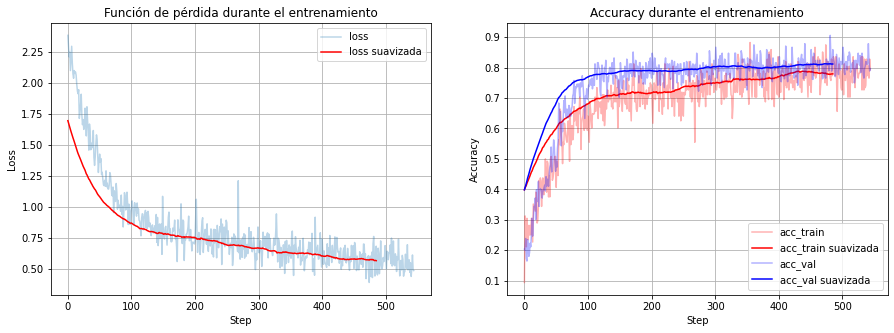

In [11]:
fig_train_base, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_loss(loss_list, ax[0])
plot_acc(acc_list, acc_val_list, ax[1])
fig_train_base.savefig("train_base.svg")

In [12]:
def get_target_preds(net, loader):
    preds = []
    targets = []
    net.eval()
    for x, y in loader:
        with torch.no_grad():
            x = x.cuda()
            output = net(x).argmax(axis=1)
            targets.extend(list(y[:, 0].numpy()))
            preds.extend(list(output.cpu().numpy()))

    targets, preds = np.array(targets), np.array(preds)
    mapping = {int(k): v.capitalize() for (k, v) in info["label"].items()}
    mapping = np.vectorize(mapping.get)
    targets = mapping(targets)
    preds = mapping(preds)
    return targets, preds


from sklearn.metrics import classification_report


def get_metrics(target, pred) -> tuple:
    """
    Retorna una lista con los siguientes elementos en orden:
    accuracy, precision, recall, f1-score, support
    """
    report_dict = classification_report(target, pred, output_dict=True)
    return report_dict["accuracy"], *report_dict["weighted avg"].values()


def eval_model(net) -> pd.DataFrame:
    train_target, train_pred = get_target_preds(net, train_loader)
    val_target, val_pred = get_target_preds(net, val_loader)
    test_target, test_pred = get_target_preds(net, test_loader)
    columns = pd.MultiIndex.from_product(
        [
            ["Train", "Val", "Test"],
            ["accuracy", "precision", "recall", "f1-score", "support"],
        ]
    )

    df = pd.DataFrame(columns=columns)
    df.loc["Base", "Train"] = get_metrics(train_target, train_pred)
    df.loc["Base", "Val"] = get_metrics(val_target, val_pred)
    df.loc["Base", "Test"] = get_metrics(test_target, test_pred)

    from sklearn.metrics import ConfusionMatrixDisplay

    fig, ax = plt.subplots(1, 2)
    ConfusionMatrixDisplay.from_predictions(
        train_target,
        train_pred,
        colorbar=False,
        ax=ax[0],
        xticks_rotation=60,
        cmap="binary",
    )
    ax[0].set_title("Train")
    ConfusionMatrixDisplay.from_predictions(
        val_target,
        val_pred,
        colorbar=False,
        ax=ax[1],
        xticks_rotation=60,
        cmap="binary",
    )
    ax[1].set_title("Val")
    fig.tight_layout()
    return df, fig

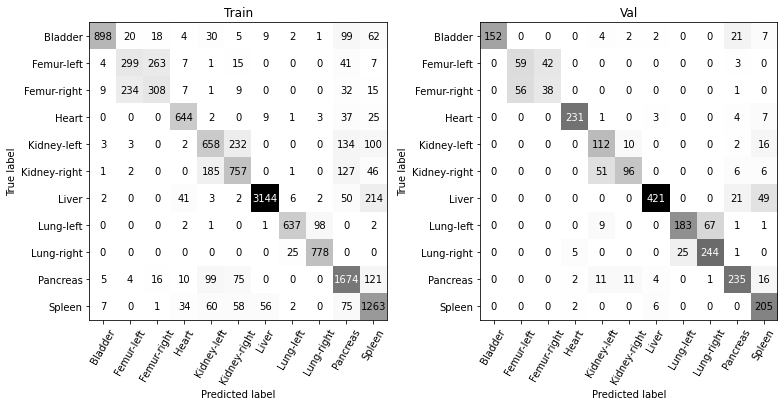

In [13]:
df_base, fig_conf_matr_base = eval_model(net)

In [14]:
df_base_aux = pd.pivot_table(
    df_base.T.reset_index(), values="Base", index="level_0", columns="level_1"
)
df_base_aux.applymap(lambda x: round(x, 3)).loc[["Train", "Val"]].iloc[:, :4]

level_1,accuracy,f1-score,precision,recall
level_0,,,,
Train,0.793,0.794,0.801,0.793
Val,0.806,0.807,0.823,0.806


In [16]:
fig_conf_matr_base.savefig("conf_matr_base.svg")

### Guardo el modelo

In [ ]:
# torch.save(net.state_dict(), "./cnn.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [ ]:
# # Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
# net = NetCNN(n_classes=n_classes)
# net.load_state_dict(torch.load("./cnn.pth"))
# net.to(device)